<a href="https://colab.research.google.com/github/iwatsuki-yuuki/intern/blob/main/%E6%B1%82%E4%BA%BA%E5%88%86%E6%9E%90%E5%BF%9C%E5%8B%9F%E8%80%85%E7%AE%A1%E7%90%86%E3%82%B7%E3%83%BC%E3%83%88_%EF%BC%88%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E6%B7%BB%E4%BB%98%E5%8F%AF%E8%83%BD%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 応募者管理シート求人分析

応募者管理シートとindeedの求人のAT、CTR率をもとに適切な求人タイトルと求人原稿を作成するツールを開発する

時系列ごとの求人の応募率の増加やAIによる原稿タイトル修正案の出力、タイトルごとのAT率の機械学習を用いた予測などの機能が備わったシステム


## 1. セットアップ

In [1]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類器
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラス
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from google.colab import files
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語フォント対応

In [3]:
!pip install japanize_matplotlib # 日本語フォントのインストール

## 2. データ読み込み

In [4]:
import pandas as pd
from google.colab import files

# ===== 1つ目：応募者管理シートをアップロード =====
print("👉 まず『応募者管理シート（管理データ）』のCSVをアップロードしてください")
uploaded_1 = files.upload()

# data_1 に読み込み（応募者管理用）
for filename in uploaded_1.keys():
    if filename.endswith('.csv'):
        data_1 = pd.read_csv(filename)
        print(f"✅ 応募者管理シート {filename} を data_1 に読み込みました")

# ===== 2つ目：indeed出力ファイルをアップロード =====
print("👉 次に『indeed出力CSV』をアップロードしてください")
uploaded_2 = files.upload()

# data_2 に読み込み（indeedデータ用）
for filename in uploaded_2.keys():
    if filename.endswith('.csv'):
        data_2 = pd.read_csv(filename)
        print(f"✅ indeed出力 {filename} を data_2 に読み込みました")


👉 まず『応募者管理シート（管理データ）』のCSVをアップロードしてください


Saving 株式会社ファクトリーシャハン応募管理シート - 新indeedのコヒー.csv to 株式会社ファクトリーシャハン応募管理シート - 新indeedのコヒー.csv
✅ 応募者管理シート 株式会社ファクトリーシャハン応募管理シート - 新indeedのコヒー.csv を data_1 に読み込みました
👉 次に『indeed出力CSV』をアップロードしてください


Saving JobsCampaigns_20241101_20250626 (1).csv to JobsCampaigns_20241101_20250626 (1) (9).csv
✅ indeed出力 JobsCampaigns_20241101_20250626 (1) (9).csv を data_2 に読み込みました


職業カテゴリーを変数に格納する（職業別有効キーワードpdfを照らし合わせて、AIの効求人タイトルと求人原稿改善案を高めるため）

In [5]:
job_category = data_1['職業カテゴリー'].unique()
job_category

array(['整体師、鍼灸師、セラピスト', '整体師、鍼灸師、スポーツ講師/トレーナー'], dtype=object)

この2つのデータをドッキングする

data_2に原稿を追加する

In [6]:
# data_2の中から募集中のデータだけ取り出す
data_2 = data_2[data_2['求人のステータス'] == '募集中']

In [7]:
# data_1の会社名とdata_2企業名の一致するデータをconcatする
data = pd.merge(data_1, data_2, left_on='会社名', right_on='企業名')

In [8]:
data.head()

,案件No,案件名（派遣先、エリアなどを記載）,紹介先（事業所）,会社名,メモ備考：採用条件など,ステータス,会社名.1,職種名,職業カテゴリー,求人キャッチコピー,...,応募率 (AR),費用,求人URL,掲載元サイト,最終更新日,参照番号,作成日,企業名,カテゴリー,求人のステータス
0,1,施術スタッフ,NaN,カラダファクトリー 大倉山店,NaN,募集中,カラダファクトリー 大倉山店,【施術スタッフ】未経験からでも安心の環境！,整体師、鍼灸師、セラピスト,資格取得支援あり！年収700万円以上可能！5日以上の連休取得も推奨！毎月インセン有！国内外3...,...,0.0,548,http://jp.indeed.com/job/%E5%AE%89%E5%BF%83%E3...,Indeed,2025-06-06,70355491-3686-1,2025-06-05,カラダファクトリー 大倉山店,"dae_saiyou@factoryjapan.co.jp,dae_oubokanri@ma...",募集中
1,1,施術スタッフ,NaN,カラダファクトリー 大倉山店,NaN,募集中,カラダファクトリー 大倉山店,【施術スタッフ】未経験からでも安心の環境！,整体師、鍼灸師、セラピスト,資格取得支援あり！年収700万円以上可能！5日以上の連休取得も推奨！毎月インセン有！国内外3...,...,0.0,1090,http://jp.indeed.com/job/%E6%96%BD%E8%A1%93%E3...,Indeed,2025-06-06,70355491-3698-1,2025-06-05,カラダファクトリー 大倉山店,"dae_saiyou@factoryjapan.co.jp,dae_oubokanri@ma...",募集中
2,1,施術スタッフ,NaN,カラダファクトリー 大倉山店,NaN,募集中,カラダファクトリー 大倉山店,【施術スタッフ】未経験からでも安心の環境！,整体師、鍼灸師、セラピスト,資格取得支援あり！年収700万円以上可能！5日以上の連休取得も推奨！毎月インセン有！国内外3...,...,0.0,433,http://jp.indeed.com/job/%E3%82%B9%E3%83%9D%E3...,Indeed,2025-06-06,70355491-3662-1,2025-06-05,カラダファクトリー 大倉山店,"dae_saiyou@factoryjapan.co.jp,dae_oubokanri@ma...",募集中
3,2,施術スタッフ,NaN,カラダファクトリー 相鉄ライフやよい台店,NaN,募集中,カラダファクトリー 相鉄ライフやよい台店,【施術スタッフ】未経験からでも安心の環境！,整体師、鍼灸師、セラピスト,資格取得支援あり！年収700万円以上可能！5日以上の連休取得も推奨！毎月インセン有！国内外3...,...,0.0,16,http://jp.indeed.com/job/%E5%AE%89%E5%BF%83%E3...,Indeed,2025-06-06,70355491-3826-1,2025-06-05,カラダファクトリー 相鉄ライフやよい台店,"dae_saiyou@factoryjapan.co.jp,dae_oubokanri@ma...",募集中
4,2,施術スタッフ,NaN,カラダファクトリー 相鉄ライフやよい台店,NaN,募集中,カラダファクトリー 相鉄ライフやよい台店,【施術スタッフ】未経験からでも安心の環境！,整体師、鍼灸師、セラピスト,資格取得支援あり！年収700万円以上可能！5日以上の連休取得も推奨！毎月インセン有！国内外3...,...,0.0,603,http://jp.indeed.com/job/%E6%96%BD%E8%A1%93%E3...,Indeed,2025-06-06,70355491-3719-1,2025-06-05,カラダファクトリー 相鉄ライフやよい台店,"dae_saiyou@factoryjapan.co.jp,dae_oubokanri@ma...",募集中


In [9]:
# 必要なカラム名だけ取り出し
columns_to_extract = [
    '求人','仕事内容（仕事内容）', '仕事内容（アピールポイント）', '仕事内容（求める人材）',
    '仕事内容（勤務時間・曜日）', '仕事内容（休暇・休日）', '仕事内容（勤務地）',
      '都道府県', '市区町村',
    '表示回数', 'クリック数', '応募開始数', '応募数',
    'クリック単価（CPC）', '応募開始単価（CPAS）', '応募単価（CPA）',
    'クリック率（CTR）', '応募完了率', '応募開始率 (ASR)', '応募率 (AR)',
    '費用', '企業名'
]

# 必要なカラムだけを抽出
data = data[columns_to_extract]

## 3. データの分析・EDA

In [10]:
! pip install japanize_matplotlib

In [11]:
numeric_cols = data.select_dtypes(include=['number']).columns

In [12]:
numeric_cols

Index(['表示回数', 'クリック数', '応募開始数', '応募数', 'クリック単価（CPC）', '応募開始単価（CPAS）',
       '応募単価（CPA）', 'クリック率（CTR）', '応募完了率', '応募開始率 (ASR)', '応募率 (AR)', '費用'],
      dtype='object')

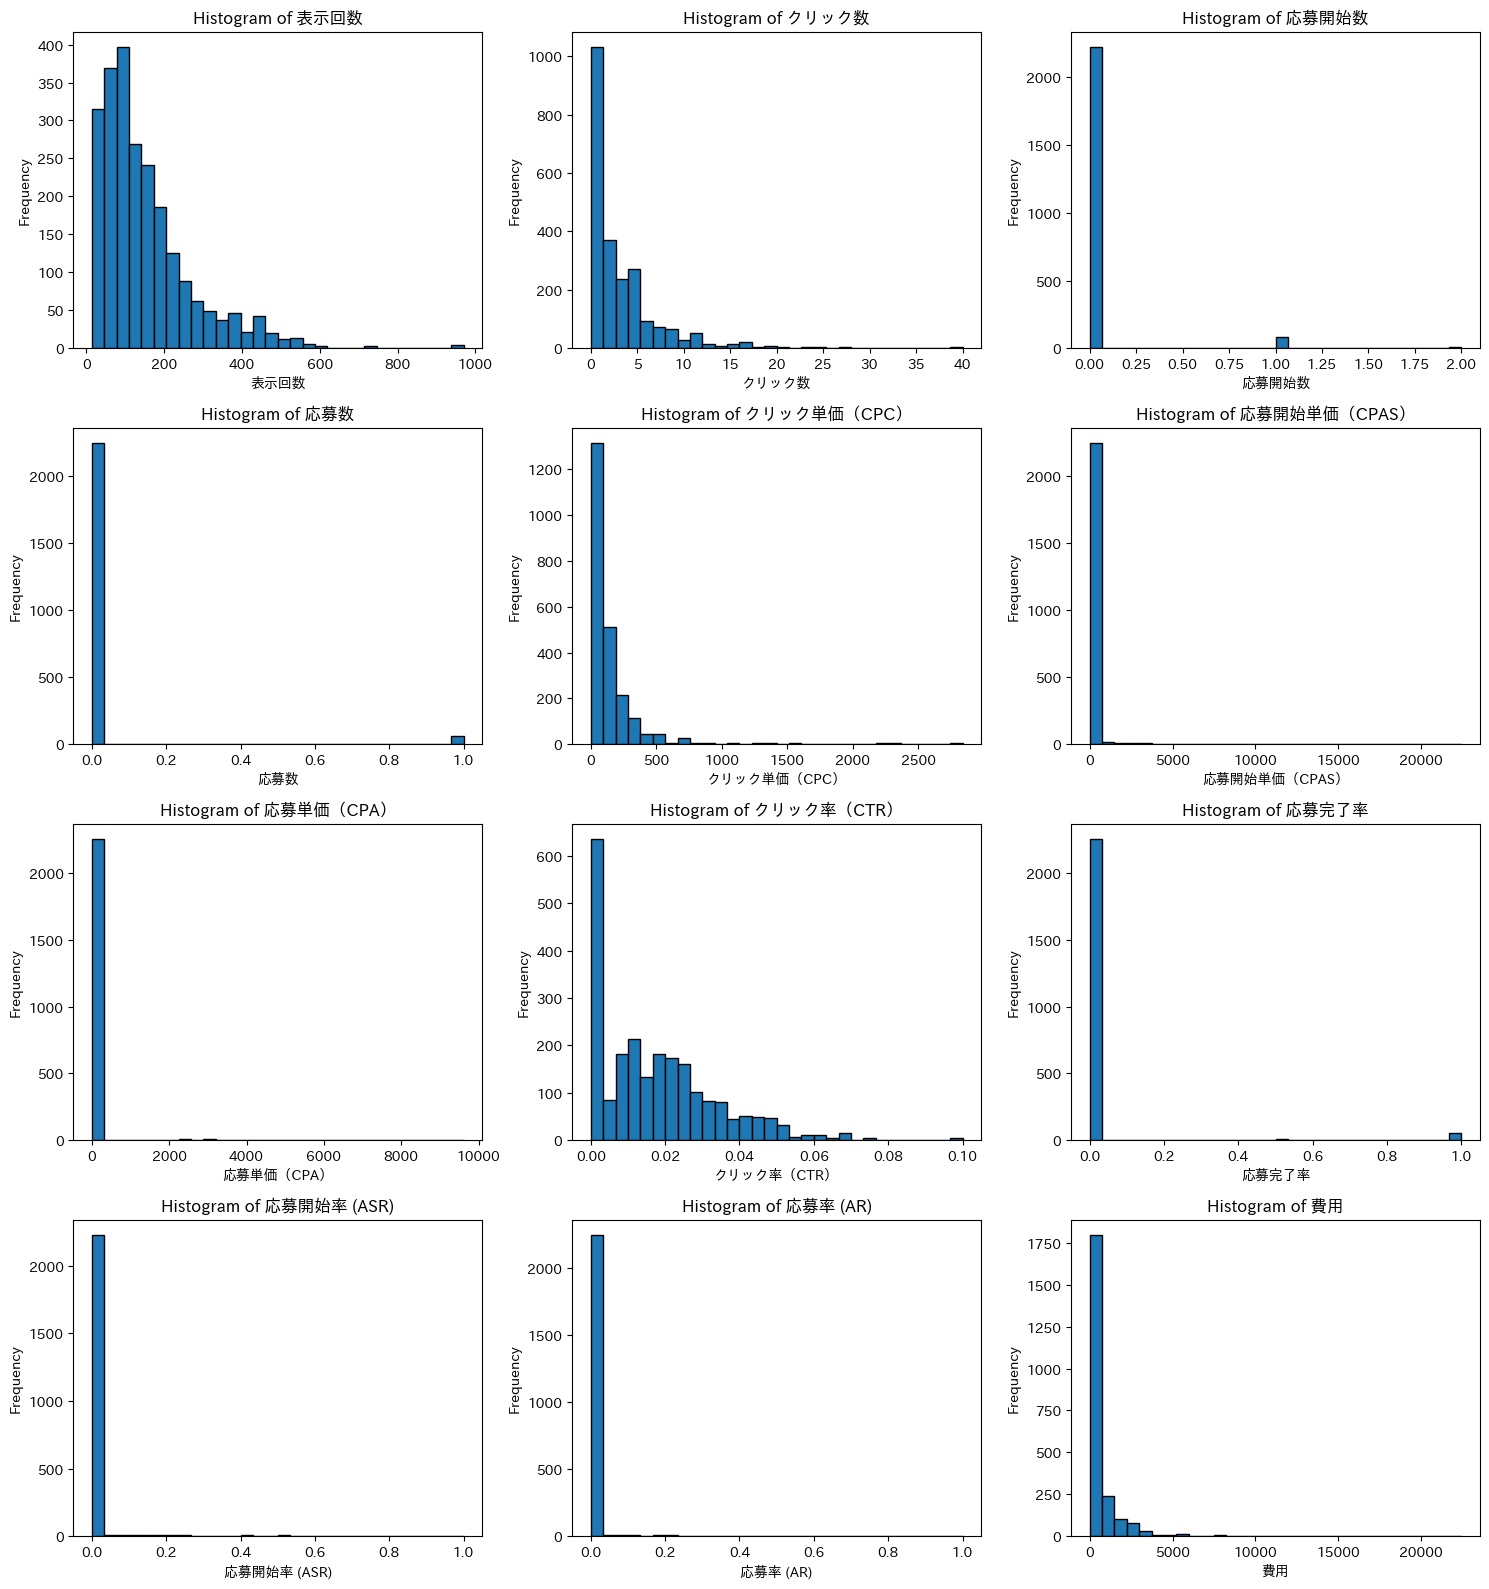

In [13]:
# 最頻値をプロット
num_cols = len(numeric_cols)
cols = 3
rows = (num_cols + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    plt.hist(data[col].dropna(), bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
# カテゴリデータを抽出
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# 各列の水準数を取得（levelはデータの種類を表す）
levels_count = {col: data[col].nunique() for col in categorical_cols}

for col, count in levels_count.items():
    print(f"{col}: {count} levels")


求人: 7 levels
仕事内容（仕事内容）: 7 levels
仕事内容（アピールポイント）: 7 levels
仕事内容（求める人材）: 3 levels
仕事内容（勤務時間・曜日）: 3 levels
仕事内容（休暇・休日）: 2 levels
仕事内容（勤務地）: 159 levels
都道府県: 7 levels
市区町村: 101 levels
企業名: 163 levels


求人タイトルと原稿には7種類しかない

この中から分析する

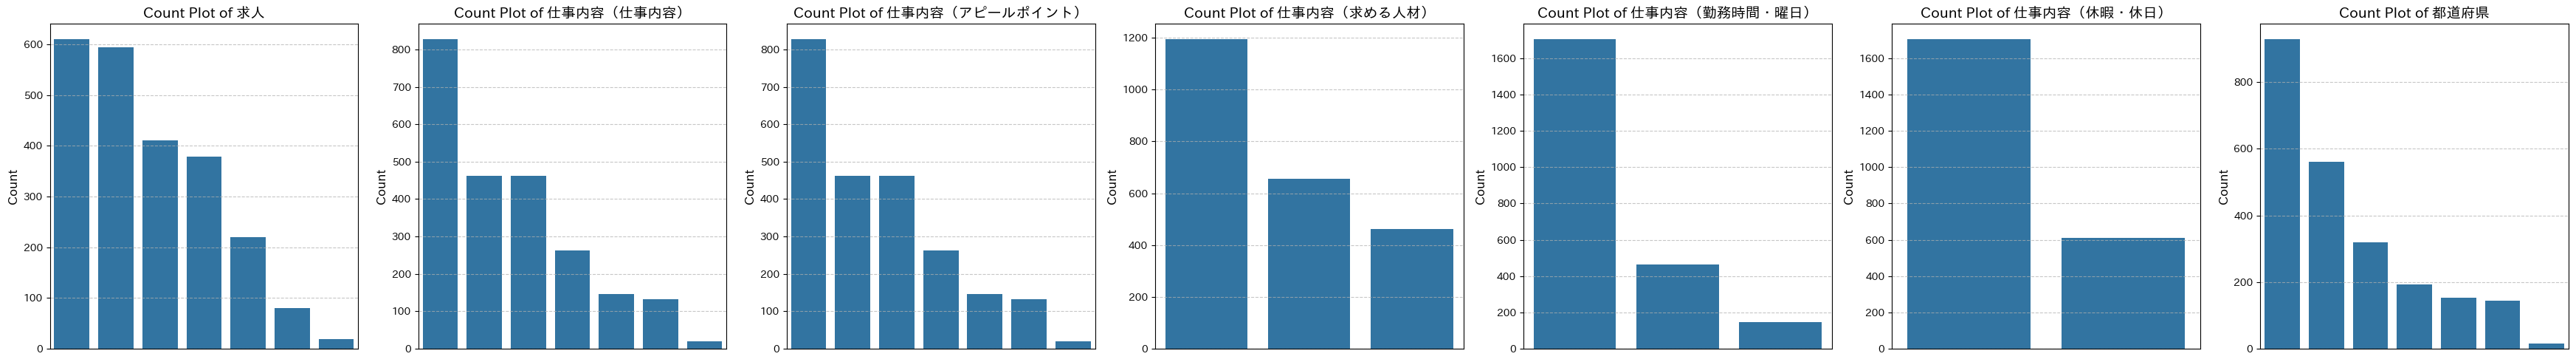

In [15]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop(['市区町村', '企業名', '仕事内容（勤務地）'])

# グラフ描画準備
num_cols = len(categorical_cols)
rows = 1
cols = num_cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))

if cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 各カテゴリ変数でカウントプロット
# 各カテゴリ変数でカウントプロット（x軸非表示）
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=data, order=data[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Count Plot of {col}', fontsize=14)
    axes[i].set_xlabel("")  # ラベル非表示
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', bottom=False, labelbottom=False)  # x軸の目盛とラベル非表示
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

次に、カテゴリデータについて、各水準の応募率の平均値を可視化

どの求人がドラフトされやすいのかを視覚的に理解できる

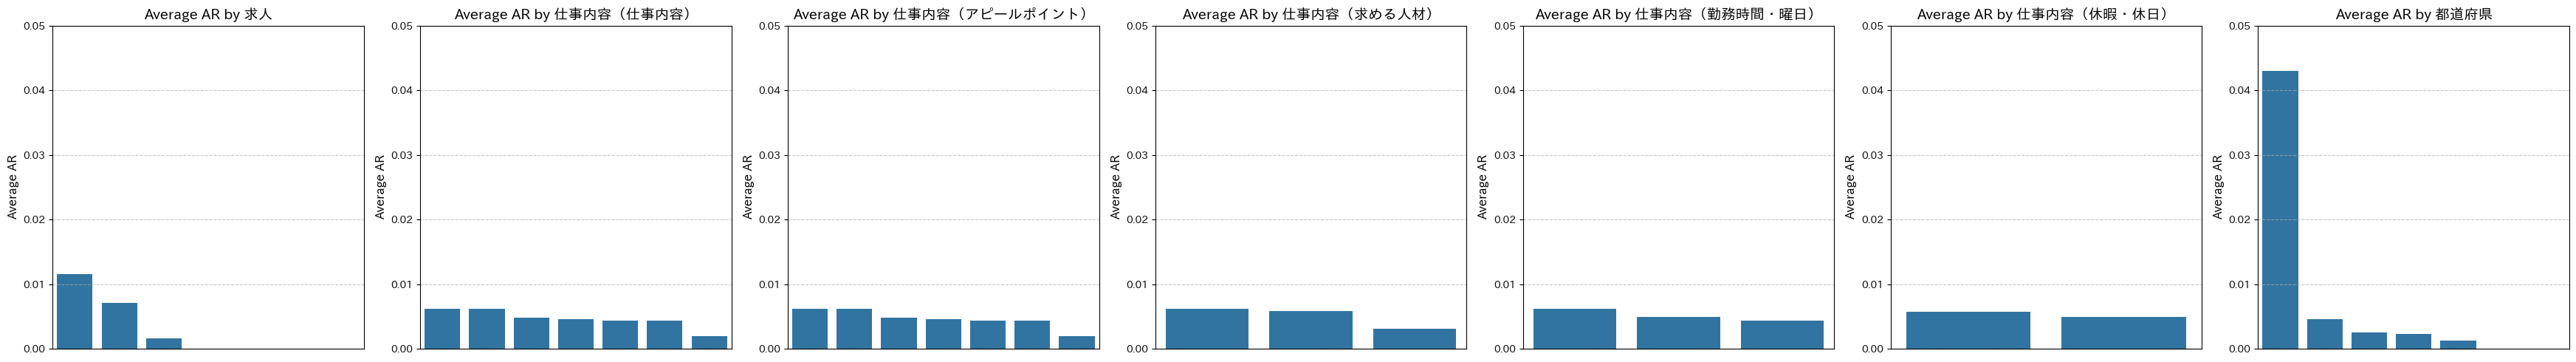

In [16]:
# グラフ描画準備
num_cols = len(categorical_cols)
rows = 1
cols = num_cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))

if cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 各カテゴリ変数ごとに Drafted 列の平均を棒グラフで描画
for i, col in enumerate(categorical_cols):
    mean_values = data.groupby(col)['応募率 (AR)'].mean().sort_values(ascending=False)
    sns.barplot(x=mean_values.index, y=mean_values.values, ax=axes[i])
    axes[i].set_title(f'Average AR by {col}', fontsize=14)
    axes[i].set_xlabel("")  # x軸ラベル非表示
    axes[i].set_ylabel('Average AR', fontsize=12)
    axes[i].set_ylim(0, 0.05)

    # x軸の目盛とラベル非表示
    axes[i].tick_params(axis='x', bottom=False, labelbottom=False)

    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

ARが0.006を超えた求人タイトル

In [17]:
best_title_ar = {}

# 各カテゴリ変数ごとに平均CTRを計算し、0.006を超える値を抽出して辞書に保存
for col in categorical_cols:
    mean_values = data.groupby(col)['応募率 (AR)'].mean()

    # 0.2を超えるカテゴリ値だけ抽出
    high_ar = mean_values[mean_values > 0.006]

    # 辞書に保存（Series → dict化しておくと扱いやすい）
    if not high_ar.empty:
        best_title_ar[col] = high_ar.to_dict()

In [18]:
# best_title のうち '求人' カテゴリに該当する value をリスト化
best_job_titles_ar = list(best_title_ar.get('求人', {}).keys())
best_job_titles_ar

['【整体師】未経験からでも安心の環境!', 'スポーツトレーナー/未経験可/研修充実!']

ARが0.006を超えた求人原稿

In [19]:
# 求人原稿でもリスト化
target_cols_content = [
    '仕事内容（仕事内容）',
    '仕事内容（アピールポイント）',
    '仕事内容（求める人材）',
    '仕事内容（勤務時間・曜日）',
    '仕事内容（休暇・休日）'
]

# 空の辞書に結果を保存）
high_ar_lists = {}

for col in target_cols_content:
    # 平均CTRをカテゴリごとに算出
    mean_values = data.groupby(col)['応募率 (AR)'].mean()

    # 0.006以上のvalueだけ抽出
    high_ar_values = mean_values[mean_values > 0.006].index.tolist()

    # 列名から変数名を変換（全角や括弧を除去して英字化・短縮化もOK）
    var_name = col.replace('（', '_').replace('）', '').replace('・', '_').replace(' ', '').replace('仕事内容', 'job').replace('アピールポイント', 'appeal').replace('求める人材', 'who').replace('勤務時間_曜日', 'time').replace('休暇_休日', 'holiday')

    # 辞書に格納
    high_ar_lists[var_name] = high_ar_values

In [20]:
high_ar_lists

{'job_job': ['━━━━━━━━━━━━━━━━━━━━\n◎ スポーツでの怪我や挫折を経験したあなたへ ◎\n━━━━━━━━━━━━━━━━━━━━\n「支える側」として再び輝ける場所！\n\n▼▼ 未経験からの挑戦、大歓迎！ ▼▼\n◎充実の研修制度で安心スタート！\n\n◆◇◆ 完全未経験でも安心！ ◆◇◆\n◎専任講師による基礎研修\n◎実践形式でスキルが身に付く\n◎配属後もOJT＆定期面談で継続支援\n\n→段階別のカリキュラムだから、\n\u3000ゼロからでもしっかり習得可能！\n\n▽▽▽ お仕事内容 ▽▽▽\n・お客様の身体状況をヒアリング\n・姿勢・骨格バランスのチェック\n・症状に応じた施術（もみほぐし等）\n・施術後のセルフケア提案\n\n▼1日の流れ▼\n①受付／問診票を記入いただきます\n②カウンセリング／最適施術を提案\n③施術／オーダーメイド対応\n④説明／原因と日常ケアを説明\n\n★平日：5〜10名、休日：10〜20名を対応',
  '◎◎ 年収700万円も目指せる！ ◎◎\n『ありがとう』が溢れる職場で、\n癒しと成長を同時に手に入れる！\n\n◆◇◆ この仕事の魅力 ◆◇◆\n◆完全週休2日制で私生活も充実\n◆未経験から手に職をつけられる\n◆年収700万円以上も夢じゃない！\n→実績に応じて収入アップが可能！\n→月収50万円以上のスタッフも在籍中\n\n◆◇◆ お仕事内容 ◆◇◆\n◎ハートフルな接客＆施術\n・お身体の状態をヒアリング\n・バランスや姿勢をチェック\n・もみほぐし＆骨格調整を実施\n・セルフケアのご提案・助言も\n\n◆◇◆ 1日の流れ（例） ◆◇◆\n【受付】\n問診票でお身体やご希望を確認\n↓\n【カウンセリング】\n最適なコースをご提案\n↓\n【施術】\n状態に合わせた施術を実施\n↓\n【説明・アドバイス】\n原因と改善策をご案内\n\n★平日：5〜10名、休日：10〜20名を対応'],
 'job_appeal': ['━━━━━━━━━━━━━━━━━━━\n◎ “本物の技術”が身に付く理由 ◎\n━━━━━━━━━━━━━━━━━━━\n\n◎現場で活かせる手技を一から学べる\n◎あなた専属のサポート担当が在籍\n◎成長に応じた昇給・キャリアアップも\n\n「自分にでき

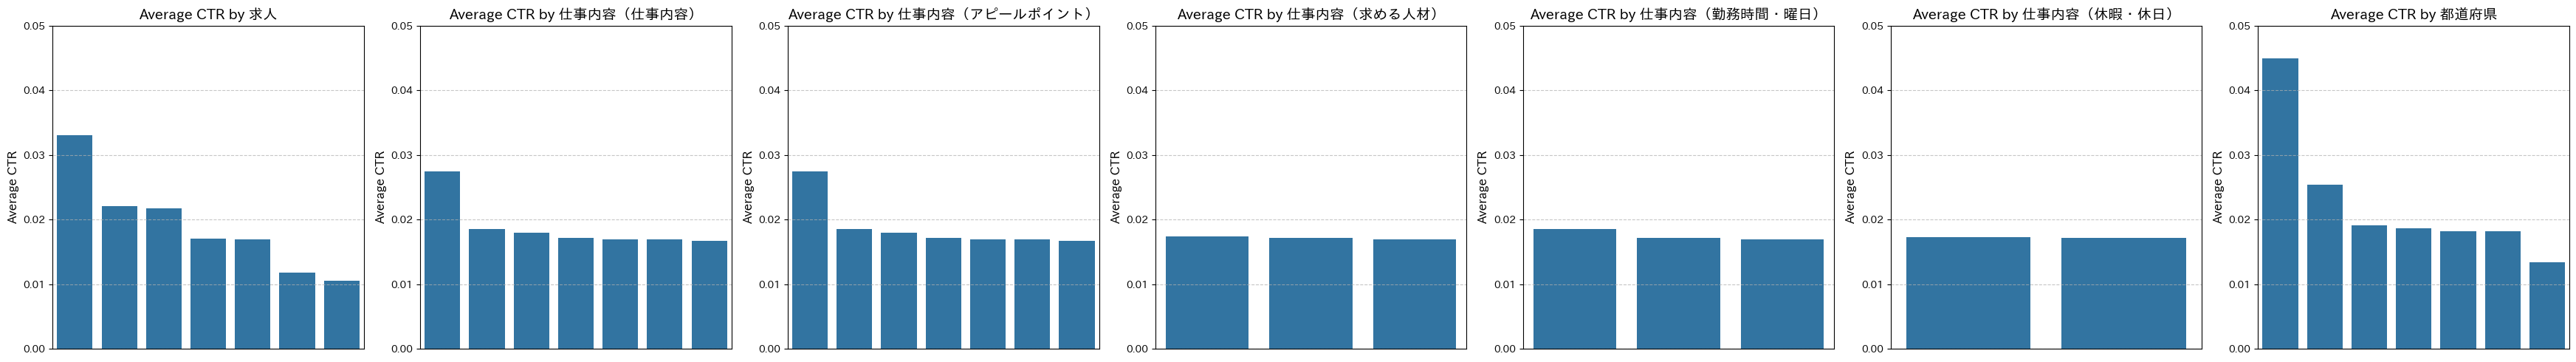

In [21]:
# グラフ描画準備
num_cols = len(categorical_cols)
rows = 1
cols = num_cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5))

if cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# 各カテゴリ変数ごとに Drafted 列の平均を棒グラフで描画
for i, col in enumerate(categorical_cols):
    mean_values = data.groupby(col)['クリック率（CTR）'].mean().sort_values(ascending=False)
    sns.barplot(x=mean_values.index, y=mean_values.values, ax=axes[i])
    axes[i].set_title(f'Average CTR by {col}', fontsize=14)
    axes[i].set_xlabel("")  # x軸ラベル非表示
    axes[i].set_ylabel('Average CTR', fontsize=12)
    axes[i].set_ylim(0, 0.05)

    # x軸の目盛とラベル非表示
    axes[i].tick_params(axis='x', bottom=False, labelbottom=False)

    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

CTRが0.02を上回るタイトル

In [22]:
best_title_ctr = {}

# 各カテゴリ変数ごとに平均CTRを計算し、0.2を超える値を抽出して辞書に保存
for col in categorical_cols:
    mean_values = data.groupby(col)['クリック率（CTR）'].mean()

    # 0.2を超えるカテゴリ値だけ抽出
    high_ctr = mean_values[mean_values > 0.02]

    # 辞書に保存（Series → dict化しておくと扱いやすい）
    if not high_ctr.empty:
        best_title_ctr[col] = high_ctr.to_dict()

In [23]:
# best_title のうち '求人' カテゴリに該当する value をリスト化
best_job_titles_ar = list(best_title_ctr.get('求人', {}).keys())
best_job_titles_ar

['【施術スタッフ】未経験からでも安心の環境!', '【未経験でも安心の研修制度】セラピスト', 'スポーツトレーナー/未経験可/研修充実!']

CTRが0.02を超える求人原稿

In [24]:
# 求人原稿でもリスト化
target_cols_content = [
    '仕事内容（仕事内容）',
    '仕事内容（アピールポイント）',
    '仕事内容（求める人材）',
    '仕事内容（勤務時間・曜日）',
    '仕事内容（休暇・休日）'
]

# 空の辞書に結果を保存）
high_ctr_lists = {}

for col in target_cols_content:
    # 平均CTRをカテゴリごとに算出
    mean_values = data.groupby(col)['クリック率（CTR）'].mean()

    # 0.2以上のvalueだけ抽出
    high_ctr_values = mean_values[mean_values > 0.02].index.tolist()

    # 列名から変数名を変換（全角や括弧を除去して英字化・短縮化もOK）
    var_name = col.replace('（', '_').replace('）', '').replace('・', '_').replace(' ', '').replace('仕事内容', 'job').replace('アピールポイント', 'appeal').replace('求める人材', 'who').replace('勤務時間_曜日', 'time').replace('休暇_休日', 'holiday')

    # 辞書に格納
    high_ctr_lists[var_name] = high_ctr_values

In [25]:
high_ctr_lists

{'job_job': ['◇- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ◇\n\n◎完全週休2日×長期休暇取得推奨で私生活も充実！\n◎未経験90％超！ゼロから手に職が叶う研修体制\n◎指名料＆インセンティブで最大月13万円超の支給例も！\n\n◇- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ◇\n\n【仕事内容】\n・お客様の身体の状態をヒアリング\n・姿勢・骨格バランスの確認\n・症状に応じたもみほぐし・骨格調整\n・セルフケア方法の提案、アドバイス\n\n▼1日の流れ▼\n①受付／問診票記入\n②カウンセリング／最適な施術提案\n③施術／個別に応じた施術を提供\n④説明／原因やケア方法を丁寧に説明\n\n★平日：5〜10名、休日：10〜20名対応'],
 'job_appeal': ['━━━━━━━━━━━━━━━━━━━━━\n◎ “感謝される喜び”と“成長”を実感できる ◎\n━━━━━━━━━━━━━━━━━━━━━\n・完全未経験でも安心！3ヶ月の研修でスキル習得\n・施術スキルだけでなく、接客・コミュニケーションも習得\n・充実の教育環境とOJT＋面談サポート\n\n━━━━━━━━━━━━━━━━━━━━━\n◎ インセンティブで高収入も可能！ ◎\n━━━━━━━━━━━━━━━━━━━━━\n・2025年より新インセンティブ制度スタート\n・指名料月平均1万1500円〜最大13万8000円の実績\n・入社5年以内に年収600〜700万円の例もあり\n\n━━━━━━━━━━━━━━━━━━━━━\n◎ 健康経営優良法人取得 × キャリア支援制度 ◎\n━━━━━━━━━━━━━━━━━━━━━\n・健康経営優良法人2025（大規模法人部門）取得\n・夢や目標に応じたキャリアアップを支援する制度あり'],
 'job_who': [],
 'job_time': [],
 'job_holiday': []}

In [26]:
# 線形回帰
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_squared_error
import numpy as np

# ▼説明変数（ラベルエンコーディング済み）
X = data[["クリック率（CTR）"]]  # 例：data["求人タイトル"] がすでに LabelEncoder で数値化されている前提
y = data["応募率 (AR)"]

# ▼学習・評価用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ▼モデル学習
model = LinearRegression()
model.fit(X_train, y_train)

# ▼予測と評価
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"回帰係数: {model.coef_[0]:.4f}, 切片: {model.intercept_:.4f}")

R² score: 0.0023
RMSE: 0.0430
回帰係数: 0.0838, 切片: 0.0032


In [27]:
X = data[["クリック率（CTR）"]]  # 例：data["求人タイトル"] がすでに LabelEncoder で数値化されている前提
y = data["応募率 (AR)"]

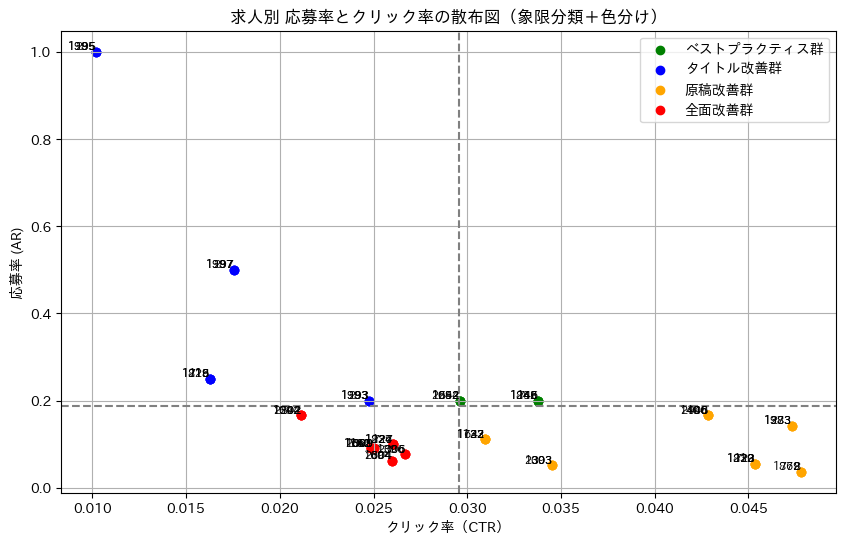

In [28]:
# 応募率 > 0 のデータのみ抽出
plot_data = data[data['応募率 (AR)'] > 0].copy()

# 中央値（または平均）を基準に象限を分類
x_mean = plot_data['クリック率（CTR）'].mean()
y_mean = plot_data['応募率 (AR)'].mean()

# 象限に応じてカテゴリ名を追加
def classify_quadrant(row):
    if row['クリック率（CTR）'] >= x_mean and row['応募率 (AR)'] >= y_mean:
        return 'ベストプラクティス群'  # 右上
    elif row['クリック率（CTR）'] < x_mean and row['応募率 (AR)'] < y_mean:
        return '全面改善群'  # 左下
    elif row['クリック率（CTR）'] >= x_mean and row['応募率 (AR)'] < y_mean:
        return '原稿改善群'  # 右下
    else:
        return 'タイトル改善群'  # 左上

plot_data['カテゴリ'] = plot_data.apply(classify_quadrant, axis=1)

# カラーマッピング
colors = {
    'ベストプラクティス群': 'green',
    'タイトル改善群': 'blue',
    '原稿改善群': 'orange',
    '全面改善群': 'red'
}

# 図の描画
plt.figure(figsize=(10, 6))

# 各カテゴリごとに散布
for category, color in colors.items():
    subset = plot_data[plot_data['カテゴリ'] == category]
    plt.scatter(subset['クリック率（CTR）'], subset['応募率 (AR)'], label=category, color=color)

# 中心線の描画
plt.axvline(x=x_mean, color='gray', linestyle='--')
plt.axhline(y=y_mean, color='gray', linestyle='--')

# インデックス表示
for i in plot_data.index:
    x = plot_data.at[i, 'クリック率（CTR）']
    y = plot_data.at[i, '応募率 (AR)']
    plt.text(x, y, str(i), fontsize=8, ha='right', va='bottom')

# ラベル・タイトル・凡例
plt.xlabel('クリック率（CTR）')
plt.ylabel('応募率 (AR)')
plt.title('求人別 応募率とクリック率の散布図（象限分類＋色分け）')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
plot_data['カテゴリ'].value_counts()

,count
カテゴリ,
原稿改善群,21
全面改善群,21
タイトル改善群,13
ベストプラクティス群,8


# +職種別のキーワードを抽出する

In [30]:
!pip install PyPDF2

In [31]:
from PyPDF2 import PdfReader
import re

def extract_keywords_from_pdf(job_category, pdf_path):
    reader = PdfReader(pdf_path)
    full_text = "\n".join(page.extract_text() for page in reader.pages if page.extract_text())
    pattern = rf"【{re.escape(job_category)}】(.*?)(?=【|$)"
    matches = re.findall(pattern, full_text, flags=re.DOTALL)
    if matches:
        words = re.split(r"[\s\n]+", matches[0].strip())
        return list(filter(None, words))
    return []

* AI提案機能の追加

In [32]:
!pip install openai
import openai
openai.api_key = "APIkey"

In [33]:
def create_prompt(job_category, keywords, good_titles, good_contents):
    prompt = f"""
あなたは求人広告の専門家です。職種「{job_category}」において、クリック率・応募率を最大化するタイトルと原稿の改善提案を行ってください。

【前提】
- 職種: {job_category}
- 高応募率のキーワード: {', '.join(keywords)}
- 高応募率のタイトル例:
{chr(10).join(['・' + t for t in good_titles])}

- 高応募率の原稿例（一部）:
{chr(10).join(['・' + t for t in good_contents])}

【出力形式】
1. 改善されたタイトル案（3案）
2. 原稿改善案（ポイント形式で3つ程度）
"""
    return prompt

In [34]:
from google.colab import files

uploaded = files.upload()
for name in uploaded.keys():
    pdf_path = name  # 1つ目のPDFファイル名を pdf_path に格納

Saving indeed 職種別キーワード (1).pdf to indeed 職種別キーワード (1) (4).pdf


In [35]:
def generate_with_gpt4(prompt):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "あなたは求人広告の改善アドバイザーです。"},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7
    )
    return response['choices'][0]['message']['content']

In [36]:
!pip install openai==0.28

In [37]:
job_category = job_category
keywords = extract_keywords_from_pdf(job_category, pdf_path)
good_titles = best_job_titles_ar[:3]
good_contents = sum(high_ar_lists.values(), [])[:3]  # flattenして一部抽出

prompt = create_prompt(job_category, keywords, good_titles, good_contents)
output = generate_with_gpt4(prompt)
print(output)

1. 改善されたタイトル案（3案）

- 【未経験歓迎】あなたの技術で人々を癒す、整体師・鍼灸師・セラピスト募集！
- 【研修充実】未経験からでも成長できる、整体師・鍼灸師・スポーツ講師/トレーナー募集！
- 【年収700万円可】技術力を駆使し、人々を元気にする整体師・鍼灸師・セラピストを募集！

2. 原稿改善案（ポイント形式で3つ程度）

- 【具体的な福利厚生の紹介】原稿には現在の福利厚生や労働環境についての情報が少ないです。具体的な福利厚生（例: 健康保険、退職金制度、社員旅行等）や労働環境（例: オフィスの設備、交通の便等）を紹介することで、求職者にとって働きやすい環境であることをアピールしましょう。

- 【キャリアパスの提示】原稿では成長に応じた昇給・キャリアアップの可能性を述べていますが、具体的なキャリアパス（例: 入社後数年での昇進の可能性、専門職への道等）を提示することで、長期的な視点での働きやすさを示すことができます。

- 【給与情報の具体化】原稿では年収700万円も可能と記載していますが、具体的な給与体系（例: 基本給、残業代、賞与等）を明示することで、求職者に対する信頼感を向上させます。また、業績に応じた給与アップのシステムを明示することで、自己成長への動機付けにも繋がります。
